In [1]:
!module load CUDA/10.2.89

# Predict on all samples after model has been trained

In [2]:
import spacy
import pandas as pd


In [3]:
!which python

/gpfs/milgram/project/rtaylor/vs428/conda_envs/prodigy/bin/python


In [4]:
spacy.__version__

'3.2.3'

In [5]:
spacy.require_gpu()


True

In [6]:
spacy.require_gpu()
nlp = spacy.load('/home/vs428/Documents/Moore/cancer_prodigy_train_dataset/model-best/',)
                 #exclude="attribute_ruler,lemmatizer,ner,parser,tagger")
# nlp_orig = spacy.load("en_core_web_trf")
# nlp.add_pipe("parser", source=nlp_orig, after="transformer")
# nlp.add_pipe("tagger", source=nlp_orig, after="parser")
# nlp.add_pipe("attribute_ruler", source=nlp_orig, after="tagger")
# nlp.add_pipe("lemmatizer", source=nlp_orig, after="attribute_ruler")
# nlp.add_pipe("ner", source=nlp_orig, after="lemmatizer")

In [16]:
analysis = nlp.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component            Assigns          Requires   Scores                    Retokenizes
-   ------------------   --------------   --------   -----------------------   -----------
0   transformer          doc._.trf_data                                        False      
                                                                                          
1   textcat_multilabel   doc.cats                    cats_score                False      
                                                     cats_score_desc                      
                                                     cats_micro_p                         
                                                     cats_micro_r                         
                                                     cats_micro_f                         
                                                     cats_macro_p                         
          

In [9]:
analysis

{'summary': {'transformer': {'assigns': ['doc._.trf_data'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'textcat_multilabel': {'assigns': ['doc.cats'],
   'requires': [],
   'scores': ['cats_score',
    'cats_score_desc',
    'cats_micro_p',
    'cats_micro_r',
    'cats_micro_f',
    'cats_macro_p',
    'cats_macro_r',
    'cats_macro_f',
    'cats_macro_auc',
    'cats_f_per_type',
    'cats_macro_auc_per_type'],
   'retokenizes': False}},
 'problems': {'transformer': [], 'textcat_multilabel': []},
 'attrs': {'doc._.trf_data': {'assigns': ['transformer'], 'requires': []},
  'doc.cats': {'assigns': ['textcat_multilabel'], 'requires': []}}}

In [10]:
# nlp.to_disk("/home/vs428/project/Moore_models/cancer_exclusion_model/model-best-fixed/")

In [7]:
# input_file = '/home/vs428/scratch60/Kevin_backup/prodigy/current cancer flags 6_23_2022.csv'
input_file = '/home/vs428/project/Moore_data/all_moore_cts.csv'

In [8]:
data_in = pd.read_csv(input_file)

In [9]:
data_in.shape[0]

26545

In [17]:
data_in['CT_Text'].sample(1).values

array(['CTA CHEST (PE) W WO IV CONTRAST  INDICATION: CP or SOB, high pretest probability PE dyspnea, metastatic pancreatic cancer  COMPARISON: None  TECHNIQUE: CT images of the chest were obtained from the lung bases through the apices after the intravenous administration of 80 cc of Omnipaque-350 contrast. Coronal and oblique 3D/MIPS reformats are provided.  Technical Limitations: None   FINDINGS: CTA: The study is technically adequate with a good contrast bolus to the pulmonary arteries. There our bilateral pulmonary emboli in the lower lobes, subsegmental on the right and segmental on the left. There is no evidence of right heart strain at this time. The central pulmonary arteries are enlarged, which may be seen in pulmonary arterial hypertension. The heart is normal in size. The aorta is normal in caliber. There is lipomatous hypertrophy of the interatrial septum. There is no pericardial effusion.  Lungs/Airways/Pleura: The central tracheobronchial tree is patent. There are scatter

In [21]:
docs = list(nlp.pipe(data_in.sample(1000)['CT_Text'].tolist()))

In [22]:
cats = [doc.cats['Cancer_on_CT'] for doc in docs]

In [23]:
cats = pd.Series(cats)#.hist()

<AxesSubplot: >

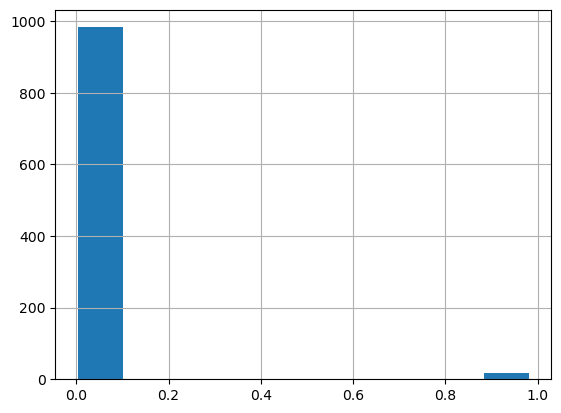

In [24]:
cats.hist()

In [25]:
cats[cats > 0.50].shape[0] / len(cats)

0.017

In [32]:
# taken from https://stackoverflow.com/a/44764557/1726404
'''
This works by using nlp.pipe and putting our records into tuples. We process it as tuples and get the context
In our work, the context is just the study id. 
We get the entity text, label, start and stop characters for each entity
we convert that to a json string, we then put the [context,json] together into a list
append this list to nlp_out
then turn nlp out into a df with 1 col being study id and the other being the nlp out
Finally we merge the df with our main data df. Now we have a column with the text
'''
import json
nlp_out = []
count = 0
for doc, ctx in nlp.pipe(list(data_in[['CT_Text', 'KL_ID']].to_records(index=False)),
                                    as_tuples=True, batch_size=50, n_process=1):
    out_ = doc.cats
    nlp_out.append([ctx, json.dumps(out_, indent = 2)])
    print(count)
    count +=1
nlp_df = pd.DataFrame(nlp_out, columns=['KL_ID', 'NLP_OUT'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
nlp_df

,KL_ID,NLP_OUT
0,KL_12943,"{\n ""Cancer_on_CT"": 0.970222532749176\n}"
1,KL_14997,"{\n ""Cancer_on_CT"": 0.9749429225921631\n}"
2,KL_10419,"{\n ""Cancer_on_CT"": 0.9740188717842102\n}"
3,KL_22683,"{\n ""Cancer_on_CT"": 0.9719998836517334\n}"
4,KL_14218,"{\n ""Cancer_on_CT"": 0.9712542295455933\n}"
...,...,...
26540,KL_24924,"{\n ""Cancer_on_CT"": 0.003048417391255498\n}"
26541,KL_18709,"{\n ""Cancer_on_CT"": 0.0030898198019713163\n}"
26542,KL_532,"{\n ""Cancer_on_CT"": 0.003029443323612213\n}"
26543,KL_6441,"{\n ""Cancer_on_CT"": 0.003035526955500245\n}"


In [34]:
# nlp_df.to_csv('task_4_TEXTCAT_GOLD_nlp_df.csv')

In [35]:
df = nlp_df

In [36]:
import ast

In [37]:
def extract_prodigy_vals(x, col_name):
    tmp = eval(x[col_name])
    pred = max(tmp, key=tmp.get)
    score = tmp[pred]
    return pred, score



In [38]:
testout = df.apply(extract_prodigy_vals, axis=1, col_name="NLP_OUT", result_type="expand")

<AxesSubplot: >

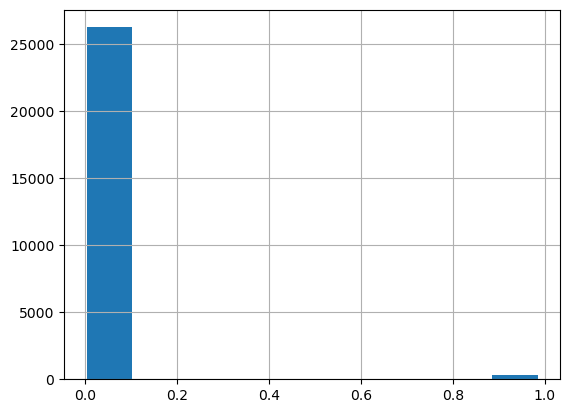

In [43]:
testout[1].hist()

In [46]:
data_in["Cancer_on_CT_NLP_score"] = testout[1]

In [48]:
data_in["Cancer_on_CT_NLP_rec"] = data_in["Cancer_on_CT_NLP_score"] > 0.5

In [79]:
data_in["Cancer_on_CT_NLP_rec"].value_counts(normalize=True)

False    0.989075
True     0.010925
Name: Cancer_on_CT_NLP_rec, dtype: float64

In [80]:
data_in

,KL_ID,Age,person_id,CT_Text,Adjudicated_Recommendation,Model_Recommendation,Nodule_model,Measurement_date,CT_type,Cancer_on_CT_NLP_score,Cancer_on_CT_NLP_rec
0,KL_12943,58,RD_13507,"Reported And Signed By: Amandeep Singh, MD** O...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2018-12-01 20:26:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,0.970223,True
1,KL_14997,86,RD_10347,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2018-11-28 08:41:00,Custom: IMG1428 CT CHEST ABDOMEN PELVIS W IV ...,0.974943,True
2,KL_10419,73,RD_2420,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2021-08-18 16:21:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,0.974019,True
3,KL_22683,59,RD_203,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2021-04-14 19:55:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST,0.972000,True
4,KL_14218,69,RD_12971,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2020-09-14 21:04:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,0.971254,True
...,...,...,...,...,...,...,...,...,...,...,...
26540,KL_24924,48,RD_4586,Yale Radiology and Biomedical Imaging** ORIGIN...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2021-10-03 05:03:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST,0.003048,False
26541,KL_18709,42,RD_1230,Yale Radiology and Biomedical Imaging** ORIGIN...,CONDITIONAL_FOLLOWUP,HARD_FOLLOWUP,Nodule,2021-11-29 15:59:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,0.003090,False
26542,KL_532,38,RD_1332,"\ CT CHEST ABDOMEN PELVIS W IV CONTRAST, CT 2D...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2020-05-11 01:22:00,Custom: IMG1428 CT CHEST ABDOMEN PELVIS W IV ...,0.003029,False
26543,KL_6441,32,RD_9508,dd CTA CHEST (PE) W IV CONTRAST INDICATION: C...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2018-07-19 06:18:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,0.003036,False


In [77]:
# print(data_in['CT_Text'].sample().squeeze())

In [78]:
print(data_in[data_in["Cancer_on_CT_NLP_rec"] == True]['CT_Text'].sample().squeeze())

CT CHEST ABDOMEN PELVIS W IV CONTRAST, CT 2D RECONSTRUCTION THORACIC SPINE (YH) Performed On 9/24/2017.  INDICATION: Fall onto a tub.  COMPARISON: No prior studies are available for comparison.  TECHNIQUE: CT images were obtained from the thoracic inlet to the pubic symphysis after the administration of 80 cc of Omnipaque-350 intravenous contrast. Coronal and sagittal multiplanar reformatted images of the chest, abdomen and pelvis were provided. Limitations: None  FINDINGS: CHEST No evidence of a mediastinal hematoma or acute traumatic injury to the great vessels.  The heart is normal in size, without pericardial effusion. There is no mediastinal, hilar or axillary lymphadenopathy.  There is scarring/atelectasis in the medial right middle lobe. Minimal dependent atelectasis is present. The central airways are patent. There is no pleural effusion or pneumothorax.   ABDOMEN AND PELVIS The liver, spleen, gallbladder, pancreas, adrenal glands and kidneys are unremarkable.  The bowel loops 

In [81]:
data_in.to_csv("/home/vs428/project/Moore_data/all_moore_cts_cancer_excl_preds.csv", index=False)

# CT Model Inference Stats

In [73]:
import jsonlines
from fuzzywuzzy import fuzz
from functools import partial
import re
import numpy as np
import spacy
from spacy.tokens import DocBin

In [11]:
anns = []
with jsonlines.open("/home/vs428/project/Moore_data/moore_cancer_exclusion_MERGED_v2.jsonl") as reader:
    for line in reader:
        anns.append(line)
        
anns1 = []
with jsonlines.open("/home/vs428/project/Moore_data/moore_cancer_exclusion_REVIEW_v2.jsonl") as reader:
    for line in reader:
        anns1.append(line)        

In [12]:
z = data_in['CT_Text'].apply(lambda row: fuzz.ratio(anns[500]['text'], row))


In [13]:
z[z > 90]

21483    100
Name: CT_Text, dtype: int64

In [14]:
assert(data_in['CT_Text'][z > 90].shape[0] == 13, "TEST")

<>:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_144388/827632215.py:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(data_in['CT_Text'][z > 90].shape[0] == 13, "TEST")


In [15]:
data_in['CT_Text'][z > 90]#.values

21483    STUDY: CT CHEST ABDOMEN PELVIS W IV CONTRAST  ...
Name: CT_Text, dtype: object

In [16]:
anns[0]['text']

'CTA CHEST (PE) W WO IV CONTRAST   History: Chest pain with positive d-dimer. Evaluate for PE.  COMPARISON: None  TECHNIQUE: Images were obtained of the chest after the administration of 90 cc of intravenous contrast. MIP images were also constructed by the technologist on the CT console.  FINDINGS:  No intraluminal filling defects are identified within the pulmonary arteries to suggest pulmonary embolus. Findings were confirmed on the sagittal and coronal and MIP reformats.  The central airways are patent. The lungs are clear without consolidation. Scattered sub-4 mm pulmonary nodules are noted; for example, a 3 mm nodule on the right upper lobe (image 31 of series 2). Bilateral lung base groundglass opacities suggesting atelectasis noted.  No axillary, hilar, or mediastinal lymphadenopathy is identified. Heart and thoracic great vessels are within normal limits for size. There is no pericardial or pleural effusion.  The visualized portion of the abdomen is unremarkable. No aggressive

In [17]:
def get_ids_on_orig_data(data_in, anns, 
                         data_text_col_name, ann_text_col_name, data_ID_col, 
                         threshold=99, verbose=False):
    '''Given the original set of data and a set of annotations (with text!), return a merged version of 
    annotations that have the ID column inserted into the annotations for downstream processing
    '''
    for idx, ann in enumerate(anns):
        if verbose:
            if idx % 10 == 0:
                print(idx/len(anns))
        ratios = data_in[data_text_col_name].apply(lambda row: fuzz.ratio(ann[ann_text_col_name], row))
        if ratios[ratios > threshold].shape[0] != 1:
            print(ratios[ratios >= threshold])
            print(data_in[ratios >= threshold][data_ID_col])
            raise Exception("Uh-oh")
        # assert(ratios[ratios > threshold].shape[0] == 1)
        if "meta" not in ann.keys():
            ann['meta'] = {}

        ann['meta'][data_ID_col] = data_in[ratios >= threshold][data_ID_col]
    
    return anns


In [33]:
data_in['CT_Text_NO_SPACES'] = data_in['CT_Text'].str.replace(r'\s', "")

/tmp/ipykernel_144388/1289011797.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_in['CT_Text_NO_SPACES'] = data_in['CT_Text'].str.replace(r'\s', "")


In [36]:
anns_df = pd.DataFrame.from_records(anns)

In [39]:
anns_df.columns

Index(['text', '_input_hash', '_task_hash', 'label', '_view_id', 'answer',
       '_timestamp', '_annotator_id', '_session_id', 'sessions', 'versions',
       'view_id', 'options', 'accept', 'config', 'text_NO_SPACES'],
      dtype='object')

In [38]:
anns_df['text_NO_SPACES'] = anns_df['text'].str.replace(r'\s', "")

/tmp/ipykernel_144388/1545001958.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  anns_df['text_NO_SPACES'] = anns_df['text'].str.replace(r'\s', "")


In [43]:
data_with_anns = data_in.merge(anns_df[['text', '_input_hash', '_task_hash', 'label',
                     'answer','_annotator_id', 'accept','text_NO_SPACES']], left_on="CT_Text_NO_SPACES", right_on="text_NO_SPACES", how="inner")

In [50]:
data_with_anns['y_true'] = np.where(data_with_anns['answer'] == "accept", 1, 0)

In [53]:
data_with_anns['y_true'].value_counts()

1    1013
0     487
Name: y_true, dtype: int64

In [56]:
data_with_anns

,KL_ID,Age,person_id,CT_Text,Adjudicated_Recommendation,Model_Recommendation,Nodule_model,Measurement_date,CT_type,CT_Text_NO_SPACES,text,_input_hash,_task_hash,label,answer,_annotator_id,accept,text_NO_SPACES,y_true
0,KL_22683,59,RD_203,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2021-04-14 19:55:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST,"ReportedAndSignedBy:BalajiRao,MD**ORIGINALREPO...","Reported And Signed By: Balaji Rao, MD** ORIGI...",1967335901,1491461382,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,"ReportedAndSignedBy:BalajiRao,MD**ORIGINALREPO...",1
1,KL_22683,59,RD_203,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2021-04-14 19:55:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST,"ReportedAndSignedBy:BalajiRao,MD**ORIGINALREPO...","Reported And Signed By: Balaji Rao, MD** ORIGI...",1967335901,1491461382,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,"ReportedAndSignedBy:BalajiRao,MD**ORIGINALREPO...",1
2,KL_21541,77,RD_8997,Exam: CTA OF THE CHEST WITH CONTRAST Clinical...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2019-03-26 02:10:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,Exam:CTAOFTHECHESTWITHCONTRASTClinicaldata:Que...,Exam: CTA OF THE CHEST WITH CONTRAST Clinical...,1648950804,568170325,Cancer_on_CT,reject,moore_cancer_exclusion-rdenkewicz,NaN,Exam:CTAOFTHECHESTWITHCONTRASTClinicaldata:Que...,0
3,KL_17768,52,RD_8812,CT angiogram of chest and abdomen with and wit...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2014-12-30 07:50:00,Custom: IMG2864 CTA CHEST ABDOMEN W AND/OR WO...,CTangiogramofchestandabdomenwithandwithoutcont...,CT angiogram of chest and abdomen with and wit...,1008537513,1091525677,Cancer_on_CT,reject,moore_cancer_exclusion-rdenkewicz,NaN,CTangiogramofchestandabdomenwithandwithoutcont...,0
4,KL_11072,85,RD_14079,STUDY: CT CHEST ABDOMEN PELVIS W IV CONTRAST ...,NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2019-02-22 14:29:00,Custom: IMG1428 CT CHEST ABDOMEN PELVIS W IV ...,STUDY:CTCHESTABDOMENPELVISWIVCONTRASTINDICATIO...,STUDY: CT CHEST ABDOMEN PELVIS W IV CONTRAST ...,-1295505958,635951000,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,STUDY:CTCHESTABDOMENPELVISWIVCONTRASTINDICATIO...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,KL_23631,72,RD_7087,Study:CTA CHEST W AND/OR WO IV CONTRAST Indic...,HARD_FOLLOWUP,HARD_FOLLOWUP,Nodule,2016-12-29 01:41:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST,Study:CTACHESTWAND/ORWOIVCONTRASTIndication:Ac...,Study:CTA CHEST W AND/OR WO IV CONTRAST Indic...,572457053,1268672001,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,Study:CTACHESTWAND/ORWOIVCONTRASTIndication:Ac...,1
1496,KL_23631,72,RD_7087,Study:CTA CHEST W AND/OR WO IV CONTRAST Indic...,HARD_FOLLOWUP,HARD_FOLLOWUP,Nodule,2016-12-29 01:41:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST,Study:CTACHESTWAND/ORWOIVCONTRASTIndication:Ac...,Study:CTA CHEST W AND/OR WO IV CONTRAST Indic...,572457053,1268672001,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,Study:CTACHESTWAND/ORWOIVCONTRASTIndication:Ac...,1
1497,KL_13080,43,RD_10143,Veronique Braxton; MR4653731; E104198262 CTA ...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2016-07-17 01:52:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,VeroniqueBraxton;MR4653731;E104198262CTACHEST(...,Veronique Braxton; MR4653731; E104198262 CTA ...,-353626991,303806915,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,VeroniqueBraxton;MR4653731;E104198262CTACHEST(...,1
1498,KL_13080,43,RD_10143,Veronique Braxton; MR4653731; E104198262 CTA ...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2016-07-17 01:52:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST,VeroniqueBraxton;MR4653731;E104198262CTACHEST(...,Veronique Braxton; MR4653731; E104198262 CTA ...,-353626991,303806915,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,VeroniqueBraxton;MR4653731;E104198262CTACHEST(...,1


In [57]:
preds = pd.read_csv("/home/vs428/project/Moore_data/all_moore_cts_cancer_excl_preds.csv")

In [75]:
doc_bin = DocBin().from_disk("/home/vs428/Documents/Moore/cancer_prodigy_train_dataset/dev.spacy")

In [78]:
# doc_bin.get_docs()
docs = list(doc_bin.get_docs(nlp.vocab))

In [84]:
import re
regex = re.compile(r'\s')


dev_texts = [regex.sub('', doc.text) for doc in docs]

In [142]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

In [61]:
data_with_anns_and_preds = data_with_anns.merge(preds[['Cancer_on_CT_NLP_score', 'Cancer_on_CT_NLP_rec', 'KL_ID']], on="KL_ID", how="inner")


In [87]:
dev_data_with_anns_and_preds = data_with_anns_and_preds[data_with_anns_and_preds['CT_Text_NO_SPACES'].isin(dev_texts)]


In [63]:
# data_with_anns_and_preds

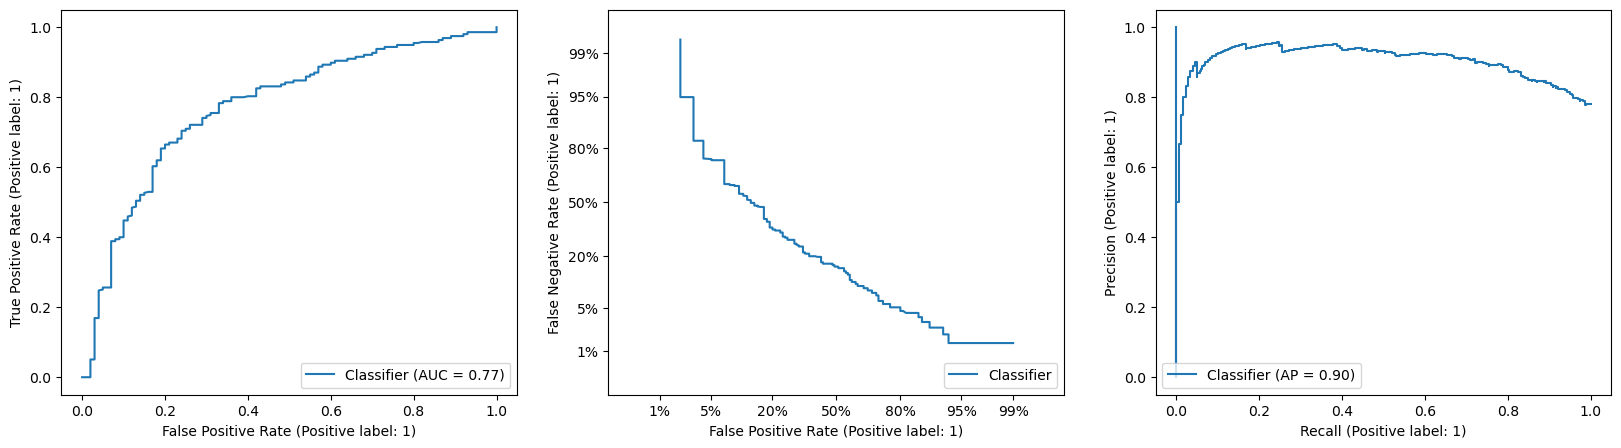

In [103]:
fig, [ax_roc, ax_det, ax_pr] = plt.subplots(1, 3, figsize=(20, 5))

RocCurveDisplay.from_predictions(dev_data_with_anns_and_preds['y_true'], dev_data_with_anns_and_preds['Cancer_on_CT_NLP_score'], ax=ax_roc,)# name=name)
DetCurveDisplay.from_predictions(dev_data_with_anns_and_preds['y_true'], dev_data_with_anns_and_preds['Cancer_on_CT_NLP_score'], ax=ax_det)#, name=name)
PrecisionRecallDisplay.from_predictions(dev_data_with_anns_and_preds['y_true'], dev_data_with_anns_and_preds['Cancer_on_CT_NLP_score'], ax=ax_pr)


In [90]:
from sklearn.metrics import det_curve


In [1]:
ConfusionMatrixDisplay.from_predictions(dev_data_with_anns_and_preds['y_true'], dev_data_with_anns_and_preds['Cancer_on_CT_NLP_rec'])


NameError: name 'ConfusionMatrixDisplay' is not defined

In [92]:
fpr, fnr, thresholds =  det_curve(dev_data_with_anns_and_preds['y_true'], dev_data_with_anns_and_preds['Cancer_on_CT_NLP_score'])


In [106]:
np.argmax(fpr == 0.05)

226

In [131]:
fpr[226], fnr[226], thresholds[226]

(0.05, 0.7436619718309859, 0.0031025817152112)

In [136]:
thresholds

array([0.00300639, 0.00301266, 0.00301269, 0.00301489, 0.00301552,
       0.00301787, 0.00301875, 0.00302015, 0.00302176, 0.00302462,
       0.0030248 , 0.00302488, 0.00302544, 0.00302704, 0.00302727,
       0.00302746, 0.00302829, 0.00303121, 0.00303249, 0.00303318,
       0.00303354, 0.00303364, 0.00303373, 0.00303376, 0.00303426,
       0.0030344 , 0.00303493, 0.00303546, 0.00303574, 0.0030358 ,
       0.00303588, 0.0030372 , 0.00303747, 0.00303755, 0.00303801,
       0.00303811, 0.00303881, 0.00303881, 0.00303897, 0.00303898,
       0.00303935, 0.00303952, 0.00303967, 0.00304039, 0.00304071,
       0.00304079, 0.00304118, 0.00304129, 0.00304238, 0.00304289,
       0.00304304, 0.00304441, 0.00304444, 0.0030446 , 0.00304474,
       0.00304544, 0.0030458 , 0.00304605, 0.00304608, 0.00304722,
       0.00304763, 0.00304764, 0.00304786, 0.00304791, 0.003048  ,
       0.00304888, 0.00304925, 0.00304954, 0.00304954, 0.00304977,
       0.00305009, 0.00305026, 0.00305096, 0.00305108, 0.00305

In [139]:
np.argmax(thresholds >= 0.5)

275

In [132]:
fpr[275], fnr[275], thresholds[275]

(0.02, 0.9943661971830986, 0.9640267491340636)

<AxesSubplot: >

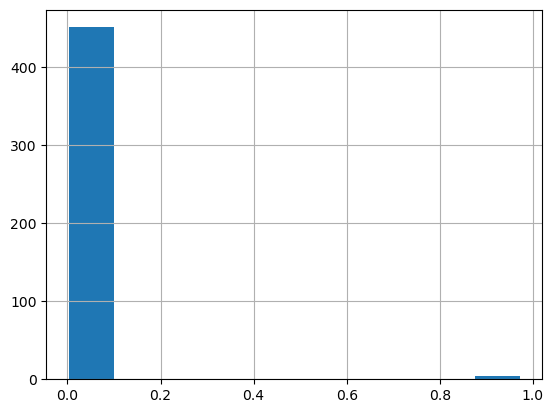

In [111]:
dev_data_with_anns_and_preds['Cancer_on_CT_NLP_score'].hist()

In [112]:
z = dev_data_with_anns_and_preds[dev_data_with_anns_and_preds['Cancer_on_CT_NLP_score'] >= thresholds[226]]


In [125]:
dev_data_with_anns_and_preds[dev_data_with_anns_and_preds['Cancer_on_CT_NLP_score'] >= 0.5]

,KL_ID,Age,person_id,CT_Text,Adjudicated_Recommendation,Model_Recommendation,Nodule_model,Measurement_date,CT_type,CT_Text_NO_SPACES,...,_input_hash,_task_hash,label,answer,_annotator_id,accept,text_NO_SPACES,y_true,Cancer_on_CT_NLP_score,Cancer_on_CT_NLP_rec
976,KL_19459,70,RD_810,CTA of the chest abdomen and pelvis with and w...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2017-09-11 14:59:00,Custom: IMG2863 CTA CHEST ABDOMEN PELVIS W AN...,CTAofthechestabdomenandpelviswithandwithoutIVc...,...,128795496,-1118479098,Cancer_on_CT,reject,moore_cancer_exclusion-rdenkewicz,NaN,CTAofthechestabdomenandpelviswithandwithoutIVc...,0,0.971873,True
1121,KL_14970,56,RD_9317,Lawrence + Memorial Hospital 365 Montauk Avenu...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2018-12-26 14:26:00,Custom: IMG1428 CT CHEST ABDOMEN PELVIS W IV ...,Lawrence+MemorialHospital365MontaukAvenueNewLo...,...,1939301235,-533006764,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,Lawrence+MemorialHospital365MontaukAvenueNewLo...,1,0.964027,True
1122,KL_14970,56,RD_9317,Lawrence + Memorial Hospital 365 Montauk Avenu...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2018-12-26 14:26:00,Custom: IMG1428 CT CHEST ABDOMEN PELVIS W IV ...,Lawrence+MemorialHospital365MontaukAvenueNewLo...,...,1939301235,-533006764,Cancer_on_CT,accept,moore_cancer_exclusion-rat4,NaN,Lawrence+MemorialHospital365MontaukAvenueNewLo...,1,0.964027,True
1123,KL_26085,58,RD_7587,Lawrence + Memorial Hospital 365 Montauk Avenu...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2019-08-13 14:57:00,Custom: IMG202 CT CHEST W IV CONTRAST,Lawrence+MemorialHospital365MontaukAvenueNewLo...,...,1360081136,-1284493802,NaN,reject,moore_cancer_exclusion-rdenkewicz,[],Lawrence+MemorialHospital365MontaukAvenueNewLo...,0,0.964717,True


In [124]:
print("After choosing a 5% FPR, we have this many predicted positive cases...")
z.shape

After choosing a 5% FPR, we have this many predicted positive cases...


(96, 21)

In [147]:
for x in z[(z['y_true'] == 1) & (z['Cancer_on_CT_NLP_rec'] == False)]['CT_Text'].to_list():
    print(x)
    print("\n\n--------------------\n\n")

****FRACTURE****  CT CHEST ABDOMEN PELVIS W IV CONTRAST  INDICATION: Status post fall. History of melanoma and squamous cell carcinoma of skin. Myelodysplastic syndrome.  COMPARISON: Recent chest and pelvis radiographs. CT abdomen pelvis 10/18/2002. MRI lumbar spine 10/24/2010.  TECHNIQUE: CT images were obtained from the thoracic inlet to the pubic symphysis after the administration of 80 cc of Omnipaque-350 intravenous contrast. Coronal and sagittal multiplanar reformatted images of the chest, abdomen and pelvis were provided. Dedicated reconstructions of the thoracic and lumbar spine were also obtained.  FINDINGS:   CHEST:  No evidence of a mediastinal hematoma or acute traumatic injury to the great vessels.  The heart is normal in size, without pericardial effusion.  There are a few subcentimeter mediastinal nodes. No axillary or hilar adenopathy.. Esophagus is patulous in appearance with layering fluid at the level of the thoracic inlet.  There is bibasilar subsegmental atelectasi

# READ OTHER, FIX FOLLOW UP ADDDITIONAL ANNOTATIONS

In [1]:

import jsonlines
import ast

In [12]:
anns1 = []
with jsonlines.open("/home/vs428/moore_followup_GOLD_context.jsonl") as reader:
    for line in reader:
        anns1.append(line)
        
anns2 = []
with jsonlines.open("/home/vs428/project/Moore_data/followup_pipeline_v1-rdenkewicz.jsonl") as reader:
    for line in reader:
        anns2.append(line)        

In [17]:
total_anns = anns1 + anns2

In [18]:
with jsonlines.open("/home/vs428/project/Moore_data/followup_pipeline_v2.jsonl", "w") as writer:
    writer.write_all(total_anns)